# Naive Bayes

Dataset Name: Wisconsin Breast cancer Dataset

Download Link:  https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

**Details**
- Shape: (570, 33)
- Training Data: 50% of original data
- Test Data: 50% of original data

Attribute Information: 
1) ID number 
2) Diagnosis (M = malignant, B = benign) 
3) Ten real-valued features are computed for each cell nucleus: 
    1. radius (mean of distances from center to points on the perimeter) 
    2. texture (standard deviation of gray-scale values) 
    3. perimeter 
    4. area 
    5. smoothness (local variation in radius lengths) 
    6. compactness (perimeter^2 / area - 1.0) 
    7. concavity (severity of concave portions of the contour) 
    8. concave points (number of concave portions of the contour) 
    9. symmetry 
    10. fractal dimension ("coastline approximation" - 1) 

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. 
For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius. 

All feature values are recorded with four significant digits. 

- Missing attribute values: none 
- Class distribution: 357 benign, 212 malignant



In [ ]:
# importing Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading dataset

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# The sharable Link
link = 'https://drive.google.com/file/d/1MBQ9zqolIxxmHeBPyUvnu0Kri909izv8'

# Get id from link
fluff, id = link.split('d/')
print (id)

# Get File from Gdrive
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('breast_cancer.csv')  

# To store dataset in a Pandas Dataframe
data = pd.read_csv('breast_cancer.csv')
data.head(10)

1MBQ9zqolIxxmHeBPyUvnu0Kri909izv8


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [ ]:
data = data.iloc[:,1:-1]
data = data.drop(["perimeter_mean","compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean","fractal_dimension_mean", "area_mean"], 1)
data = data.drop(["radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se", "fractal_dimension_se"], 1)
data = data.drop(["concavity_worst","concave points_worst", "symmetry_worst", "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst","fractal_dimension_worst"], 1)
data.head(2)


,diagnosis,radius_mean,texture_mean,smoothness_mean
0,M,17.99,10.38,0.11840
1,M,20.57,17.77,0.08474


In [ ]:

data.diagnosis = [1 if i == "M" else 0 for i in data.diagnosis] 
data = data.reindex(['radius_mean','texture_mean','smoothness_mean', 'diagnosis'], axis=1)
print(data)

     radius_mean  texture_mean  smoothness_mean  diagnosis
0          17.99         10.38          0.11840          1
1          20.57         17.77          0.08474          1
2          19.69         21.25          0.10960          1
3          11.42         20.38          0.14250          1
4          20.29         14.34          0.10030          1
..           ...           ...              ...        ...
564        21.56         22.39          0.11100          1
565        20.13         28.25          0.09780          1
566        16.60         28.08          0.08455          1
567        20.60         29.33          0.11780          1
568         7.76         24.54          0.05263          0

[569 rows x 4 columns]


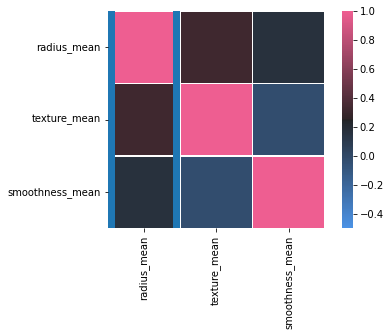

In [ ]:
# Basic Exploratory Data Analysis
data["diagnosis"].hist()

corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

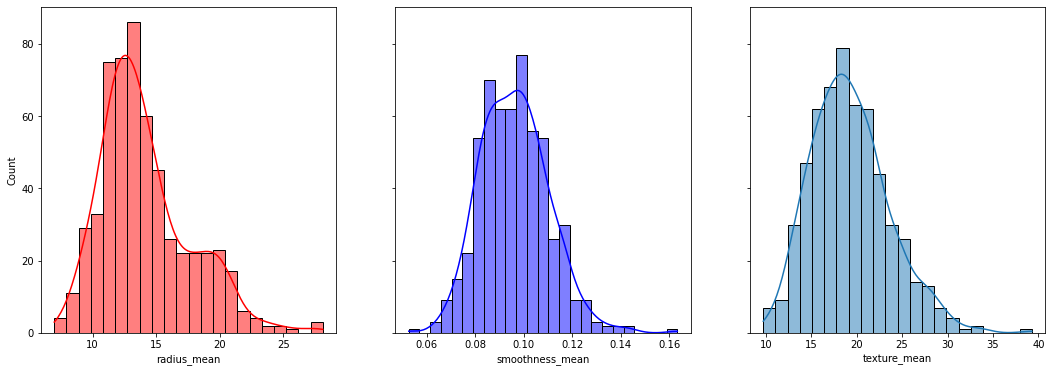

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="radius_mean", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="smoothness_mean", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="texture_mean", kde=True)

In [ ]:
# Calculate P(Y=y) for all possible y

def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

In [ ]:
# Calculate P(X=x|Y=y) using Gaussian dist
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

In [ ]:
# Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[74  0]
 [ 4 36]]
0.9473684210526316


In [ ]:
# Convert continuous features to Categorical features
data["cat_mean_radius"] = pd.cut(data["radius_mean"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["texture_mean"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["smoothness_mean"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["radius_mean", "texture_mean", "smoothness_mean"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,1
1,1,0,0,1
2,1,1,1,1
3,0,1,2,1
4,1,0,1,1
5,0,0,2,1
6,1,1,1,1
7,0,1,1,1
8,0,1,2,1
9,0,1,1,1


In [ ]:
# Approach 2: Calculate P(X=x|Y=y) categorically
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

# Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [ ]:
# Test Categorical model
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[69  5]
 [ 2 38]]
0.9156626506024096
